# Imports

In [84]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-kbq8qszi
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-kbq8qszi
  Resolved https://github.com/tensorflow/examples.git to commit 2741d0f2a345ef52e0de1d498de732f5dacbf2f0
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1694556533.224118390420868118806081040175592332373432988400-py3-none-any.whl size=301567 sha256=ed0bb729d09d7d89dfdf1677735c00d47216208e4d9efffbc9a05ef0f4674df9
  Stored in directory: /tmp/pip-ephem-wheel-cache-lylud0_2/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [85]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import PIL
import shutil
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     BatchNormalization, Input,
                                     Dropout, RandomFlip, RandomRotation,RandomZoom,RandomTranslation,
                                     RandomContrast, Rescaling, Resizing, Reshape,LeakyReLU, Conv2DTranspose)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from google.colab import drive
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow_examples.models.pix2pix import pix2pix

In [2]:
# !rm -rf /content/the-oxfordiiit-pet-dataset

In [3]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d devdgohil/the-oxfordiiit-pet-dataset

 98% 763M/780M [00:08<00:00, 102MB/s]
100% 780M/780M [00:08<00:00, 101MB/s]


In [ ]:
!unzip "/content/the-oxfordiiit-pet-dataset.zip" -d "/content/the-oxfordiiit-pet-dataset/"

[[[30. 38. 27.]
  [30. 38. 27.]
  [30. 38. 27.]
  ...
  [43. 51. 38.]
  [41. 49. 36.]
  [40. 48. 35.]]

 [[29. 37. 26.]
  [29. 37. 26.]
  [30. 38. 27.]
  ...
  [43. 51. 38.]
  [42. 50. 37.]
  [40. 48. 35.]]

 [[29. 37. 26.]
  [29. 37. 26.]
  [29. 37. 26.]
  ...
  [44. 52. 39.]
  [43. 51. 38.]
  [41. 49. 36.]]

 ...

 [[12. 19. 11.]
  [11. 18. 10.]
  [11. 18. 10.]
  ...
  [15. 23. 12.]
  [15. 23. 12.]
  [15. 23. 12.]]

 [[12. 19. 11.]
  [11. 18. 10.]
  [11. 18. 10.]
  ...
  [15. 23. 12.]
  [15. 23. 12.]
  [15. 23. 12.]]

 [[12. 19. 11.]
  [11. 18. 10.]
  [10. 17.  9.]
  ...
  [15. 23. 12.]
  [15. 23. 12.]
  [15. 23. 12.]]]


(-0.5, 599.5, 399.5, -0.5)

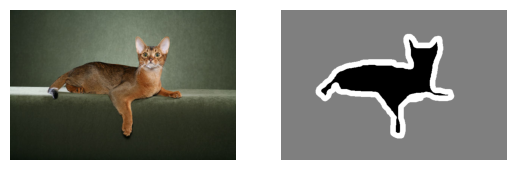

In [5]:
fig,axes = plt.subplots(1,2)
img = load_img('/content/the-oxfordiiit-pet-dataset/images/images/Abyssinian_1.jpg')
print(img_to_array(img))
axes[0].imshow(img)
axes[0].axis('off')
seg_mask = load_img('/content/the-oxfordiiit-pet-dataset/annotations/annotations/trimaps/Abyssinian_1.png')
seg_mask = PIL.ImageOps.autocontrast(seg_mask)
axes[1].imshow(seg_mask)
axes[1].axis('off')

# Data Preparation

In [6]:
class Datagenerator(tf.keras.utils.Sequence):
  def __init__(self,images_path,labels_path,batch_size,input_dim,shuffle=False):
    self.images_path = images_path
    self.labels_path = labels_path
    self.batch_size = batch_size
    self.input_dim = input_dim
    self.shuffle = shuffle

  def __len__(self):
    return int(np.floor(len(os.listdir(self.images_path))/self.batch_size))

  def __getitem__(self, idx):
    indices = np.arange(start=idx*self.batch_size, stop=(idx+1)*self.batch_size)
    if self.shuffle:
      np.random.shuffle(indices)

    x,y = self.__data_generation(indices)
    y-=1
    return np.array(x), np.array(y)

  def __data_generation(self, indices):
    x = []
    y = []
    for i in indices:
      img_name = os.listdir(self.images_path)[i]
      img_path = self.images_path+img_name
      # print(img_path)

      img = load_img(img_path,target_size=(self.input_dim,self.input_dim))
      img = img_to_array(img)
      img/=255.
      x.append(img)

      seg_mask_path = self.labels_path+img_name[:-3]+'png'
      # print(seg_mask_path)
      seg_mask = img_to_array(load_img(seg_mask_path,color_mode='grayscale',target_size=(self.input_dim//2,self.input_dim//2)))
      y.append(seg_mask)

      # add augmentation
      img_aug_sat = tf.image.adjust_saturation(img,0.5)
      x.append(img_aug_sat)
      y.append(seg_mask)

      img_aug_flip=tf.image.flip_up_down(img)
      x.append(img_aug_flip)
      y.append(tf.reverse(seg_mask,axis=-0))

    return tf.convert_to_tensor(x),tf.convert_to_tensor(y)



In [7]:
!mkdir /content/the-oxfordiiit-pet-dataset/images/val_images
!mkdir /content/the-oxfordiiit-pet-dataset/annotations/val_annotations

In [25]:
train_images_path='/content/the-oxfordiiit-pet-dataset/images/images/'
train_maps_path='/content/the-oxfordiiit-pet-dataset/annotations/annotations/trimaps/'
val_images_path='/content/the-oxfordiiit-pet-dataset/images/val_images/'
val_maps_path='/content/the-oxfordiiit-pet-dataset/annotations/val_annotations/'

LR=1e-3
# BATCH_SIZE=4
EPOCH=100
INPUT_DIM = 224
NUM_FILTERS = 128

In [9]:
os.listdir(train_images_path)[0]

'Abyssinian_142.jpg'

In [10]:
train_maps_path+'keeshond_173.png'

'/content/the-oxfordiiit-pet-dataset/annotations/annotations/trimaps/keeshond_173.png'

In [11]:
print(train_images_path+os.listdir(train_images_path)[0])

/content/the-oxfordiiit-pet-dataset/images/images/Abyssinian_142.jpg


In [12]:
train_images_len = len(os.listdir(train_images_path))
val_list = os.listdir(train_images_path)[:int(0.1*train_images_len)]
val_list

['Abyssinian_142.jpg',
 'boxer_104.jpg',
 'basset_hound_3.jpg',
 'english_setter_180.jpg',
 'Birman_159.jpg',
 'Egyptian_Mau_155.jpg',
 'japanese_chin_170.jpg',
 'samoyed_124.jpg',
 'saint_bernard_178.jpg',
 'samoyed_52.jpg',
 'shiba_inu_206.jpg',
 'Sphynx_204.jpg',
 'miniature_pinscher_50.jpg',
 'german_shorthaired_110.jpg',
 'Sphynx_122.jpg',
 'leonberger_25.jpg',
 'american_bulldog_62.jpg',
 'leonberger_11.jpg',
 'american_bulldog_45.jpg',
 'Sphynx_128.jpg',
 'Bombay_1.jpg',
 'leonberger_87.jpg',
 'Russian_Blue_62.jpg',
 'Siamese_110.jpg',
 'miniature_pinscher_56.jpg',
 'Ragdoll_8.jpg',
 'boxer_173.jpg',
 'staffordshire_bull_terrier_5.jpg',
 'Birman_78.jpg',
 'yorkshire_terrier_129.jpg',
 'american_bulldog_203.jpg',
 'Birman_53.jpg',
 'american_bulldog_122.jpg',
 'beagle_152.jpg',
 'Persian_132.jpg',
 'Maine_Coon_205.jpg',
 'Maine_Coon_159.jpg',
 'english_setter_26.jpg',
 'Egyptian_Mau_22.jpg',
 'Maine_Coon_100.jpg',
 'chihuahua_77.jpg',
 'saint_bernard_68.jpg',
 'beagle_74.jpg',
 '

In [13]:
for name in val_list:
  shutil.move(train_images_path+name[:-3]+"jpg", val_images_path+name[:-3]+"jpg")

In [14]:
for name in val_list:
  shutil.move(train_maps_path+name[:-3]+"png", val_maps_path+name[:-3]+"png")

In [47]:
train_gen = Datagenerator(train_images_path,train_maps_path,BATCH_SIZE,INPUT_DIM,True)
val_gen = Datagenerator(val_images_path,val_maps_path,BATCH_SIZE,INPUT_DIM,False)

# Getting Data using Tensorflow Datasets

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [14]:
dataset

{'train': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [15]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path=PosixGPath('/tmp/tmp0bwj8m9vtfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        

In [16]:
info.splits['train']

<SplitInfo num_examples=3680, num_shards=4>

In [17]:
string_labels = info.features['label'].names
string_labels

['Abyssinian',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'Bengal',
 'Birman',
 'Bombay',
 'boxer',
 'British_Shorthair',
 'chihuahua',
 'Egyptian_Mau',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'Maine_Coon',
 'miniature_pinscher',
 'newfoundland',
 'Persian',
 'pomeranian',
 'pug',
 'Ragdoll',
 'Russian_Blue',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'Siamese',
 'Sphynx',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [51]:
train_ds = dataset['train']
test_ds = dataset['test']

In [52]:
train_ds

<_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

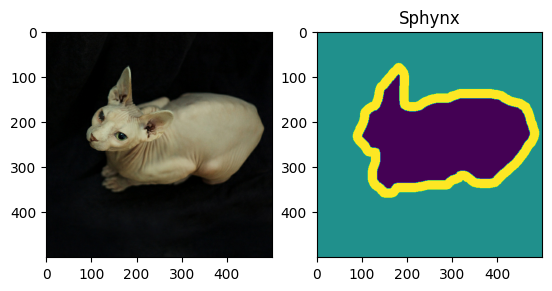

In [53]:
fig, axes = plt.subplots(1,2)
for i in train_ds.take(1):
  label = string_labels[i['label'].numpy()]
  plt.title(label)
  axes[0].imshow(i['image'])
  axes[1].imshow(i['segmentation_mask'])
  break

In [54]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [55]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (INPUT_DIM, INPUT_DIM))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (INPUT_DIM//2, INPUT_DIM//2),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask


In [56]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [57]:
train_ds = train_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)


In [58]:
test_ds = test_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [59]:
class Augment(Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    # augment input
    self.augment_inputs_flip = RandomFlip(mode="horizontal", seed=seed)
    self.augment_inputs_rotation = RandomRotation(0.2,seed=seed)
    self.augment_inputs_zoom = RandomZoom(0.2,seed=seed)
    # augment labels
    self.augment_labels_flip = RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels_rotation = RandomRotation(0.2,seed=seed)
    self.augment_labels_zoom = RandomZoom(0.2,seed=seed)


  def call(self, inputs, labels):
    inputs = self.augment_inputs_flip(inputs)
    inputs = self.augment_inputs_rotation(inputs)
    inputs = self.augment_inputs_zoom(inputs)

    labels = self.augment_labels_flip(labels)
    labels = self.augment_labels_rotation(labels)
    labels = self.augment_labels_zoom(labels)
    return inputs, labels

In [60]:
train_ds = (
    train_ds
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [61]:
test_ds = (
    test_ds
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [62]:
test_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 112, 112, 1), dtype=tf.uint8, name=None))>

# Model

We will use Resnet50 to ectract features from the dataset for the downsampling part of the Unet model

In [30]:
def get_base_model():
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet',
        input_shape=(INPUT_DIM,INPUT_DIM,3),
        include_top=False,
      )
    base_model.trainable=False

    conv1_relu,conv2_block3_out,conv3_block4_out,conv4_block6_out,conv5_block3_out=[base_model.get_layer(layer_name).output for layer_name in ["conv1_relu","conv2_block3_out","conv3_block4_out","conv4_block6_out","conv5_block3_out"]]

    return Model(
        inputs=[base_model.inputs],outputs=[conv1_relu,conv2_block3_out,conv3_block4_out,conv4_block6_out,conv5_block3_out]
    )

base_model = get_base_model()
base_model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                         

In [31]:
class Upsample(Layer):
  def __init__(self,NUM_FILTERS):
    super(Upsample,self).__init__()
    self.conv_t_1=Conv2DTranspose(NUM_FILTERS,1,strides=2,activation='relu')
    self.norm_1=BatchNormalization()
  def call(self,x):
    x = self.conv_t_1(x)
    x=self.norm_1(x)
    return x

In [32]:
class ConvLayers(Layer):
  def __init__(self,NUM_FILTERS):
    super(ConvLayers,self).__init__()
    self.conv_1=Conv2D(NUM_FILTERS*2,3,padding='same',activation='relu')
    self.norm_1=BatchNormalization()

    self.conv_2=Conv2D(NUM_FILTERS*4,3,padding='same',activation='relu')
    self.norm_2=BatchNormalization()
  def call(self,x):
    x = self.conv_1(x)
    x = self.norm_1(x)
    x = self.conv_2(x)
    x = self.norm_2(x)
    return x

In [33]:
inputs=Input(shape=(INPUT_DIM,INPUT_DIM,3))
x_112,x_56,x_28,x_14,x_7=base_model(inputs)

x=Upsample(NUM_FILTERS)(x_7)
x=tf.concat([x,x_14],axis=-1)
x=ConvLayers(NUM_FILTERS)(x)
x = Dropout(0.5)(x)

x=Upsample(NUM_FILTERS)(x)
x=tf.concat([x,x_28],axis=-1)
x=ConvLayers(NUM_FILTERS)(x)
x = Dropout(0.5)(x)


x=Upsample(NUM_FILTERS)(x)
x=tf.concat([x,x_56],axis=-1)
x=ConvLayers(NUM_FILTERS)(x)
x = Dropout(0.5)(x)


x=Upsample(NUM_FILTERS)(x)
x=tf.concat([x,x_112],axis=-1)
x=ConvLayers(NUM_FILTERS)(x)
x = Dropout(0.5)(x)

out=Conv2D(3,3,padding='same',activation='softmax')(x)
model=Model(inputs=inputs,outputs=out)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 model (Functional)          [(None, 112, 112, 64),       2358771   ['input_2[0][0]']             
                              (None, 56, 56, 256),        2                                       
                              (None, 28, 28, 512),                                                
                              (None, 14, 14, 1024),                                               
                              (None, 7, 7, 2048)]                                                 
                                                                                            

In [34]:
model.compile(
    loss = SparseCategoricalCrossentropy(),
    optimizer = Adam(learning_rate = LR),
    metrics='accuracy',
    run_eagerly = True,
)

In [35]:
checkpoint_filepath='/content/checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True
)

In [36]:
history = model.fit(
    train_ds,
    verbose=1,
    steps_per_epoch=STEPS_PER_EPOCH,
    # shuffle=True,
    epochs=30,
    callbacks=[checkpoint_callback]
)

Epoch 1/30


57/57 [==============================] - 50s 373ms/step - loss: 1.0285 - accuracy: 0.5667
Epoch 2/30
57/57 [==============================] - 22s 383ms/step - loss: 0.6923 - accuracy: 0.6462
Epoch 3/30
57/57 [==============================] - 20s 357ms/step - loss: 0.7023 - accuracy: 0.6336
Epoch 4/30
57/57 [==============================] - 20s 354ms/step - loss: 0.7009 - accuracy: 0.6432
Epoch 5/30
57/57 [==============================] - 23s 407ms/step - loss: 0.6727 - accuracy: 0.6555
Epoch 6/30
57/57 [==============================] - 20s 356ms/step - loss: 0.6807 - accuracy: 0.6502
Epoch 7/30
57/57 [==============================] - 20s 356ms/step - loss: 0.6733 - accuracy: 0.6495
Epoch 8/30
57/57 [==============================] - 20s 359ms/step - loss: 0.6817 - accuracy: 0.6411
Epoch 9/30
57/57 [==============================] - 23s 406ms/step - loss: 0.6528 - accuracy: 0.6632
Epoch 10/30
57/57 [==============================] - 21s 375ms/step - loss: 0.6507 - accuracy: 0.6554


It takes too long per epoch when using train_gen

In [94]:
# history = model.fit(
#     train_gen,
#     validation_data = val_gen,
#     verbose=1,
#     # shuffle=True,
#     epochs=EPOCH,
#     callbacks=[checkpoint_callback]
# )

Epoch 1/100


KeyboardInterrupt: ignored

In [66]:
history.history

{'loss': [1.0285379886627197,
  0.6922754645347595,
  0.7022978663444519,
  0.7009158730506897,
  0.6727164387702942,
  0.6806836128234863,
  0.6732569932937622,
  0.6817083358764648,
  0.6527584195137024,
  0.6506520509719849,
  0.6617092490196228,
  0.6422375440597534,
  0.6292914748191833,
  0.629987359046936,
  0.6443825364112854,
  0.6619120240211487,
  0.6308359503746033,
  0.6200617551803589,
  0.6313488483428955,
  0.6384108662605286,
  0.6098202466964722,
  0.6114050149917603,
  0.625754714012146,
  0.6334161758422852,
  0.6047969460487366,
  0.6041325926780701,
  0.6254495978355408,
  0.6194409728050232,
  0.6236406564712524,
  0.6154022216796875],
 'accuracy': [0.5666950345039368,
  0.6462063789367676,
  0.633648157119751,
  0.6431634426116943,
  0.655479371547699,
  0.6502130031585693,
  0.6495189666748047,
  0.6411263942718506,
  0.6632481813430786,
  0.6554234623908997,
  0.650842010974884,
  0.656536340713501,
  0.6599793434143066,
  0.6614300012588501,
  0.6620447039604

In [63]:
model.evaluate(test_ds)

58/58 [==============================] - 88s 1s/step - loss: 1.0415 - accuracy: 0.5766


[1.0415172576904297, 0.5766258835792542]

# Plot loss and accuracy vs epochs

In [72]:
def plot_loss_and_acc(model_history):
  loss = model_history.history['loss']

  plt.figure()
  plt.plot(model_history.epoch, loss, 'r', label='Training loss')
  plt.title('Training Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss Value')
  plt.legend()

  accuracy = model_history.history['accuracy']
  plt.figure()
  plt.plot(model_history.epoch, accuracy, 'r', label='Training Accuracy')
  plt.title('Training Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy Value')
  plt.legend()
  plt.show()


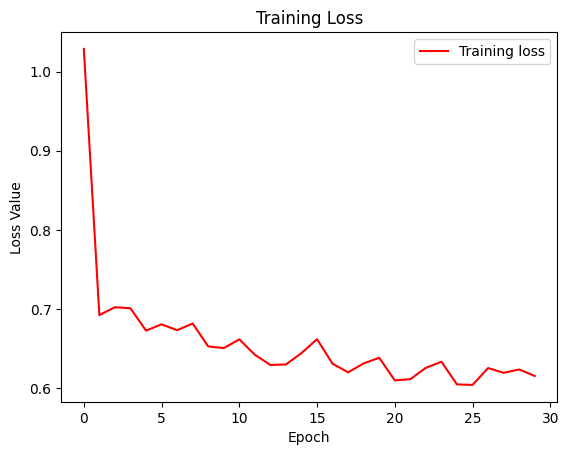

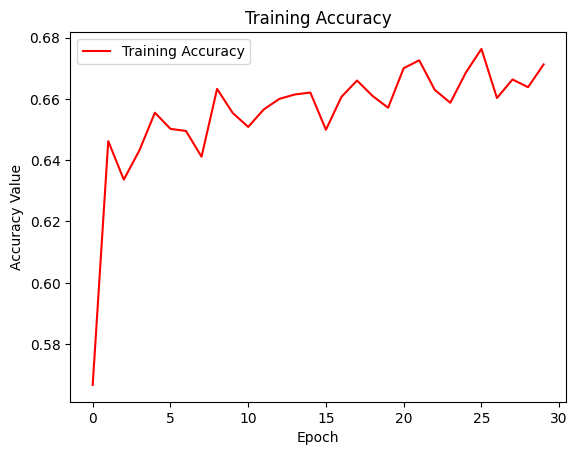

In [73]:
plot_loss_and_acc(history)

# Test the model

1/1 [==============================] - 0s 137ms/step


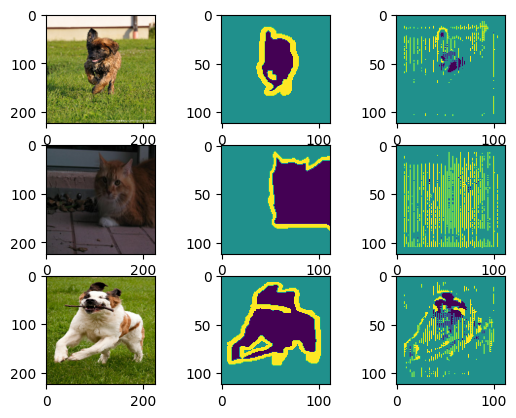

In [82]:
batch = test_ds.take(1)
for i,j in batch:
  fig, axes = plt.subplots(3,3)
  for x in range(3):
    img = tf.expand_dims(i[x],axis=0)
    label = tf.expand_dims(j[x],axis=0)
    out = tf.argmax(model.predict(img),axis=-1)[0]
    axes[x][0].imshow(i[x])
    axes[x][1].imshow(j[x])
    axes[x][2].imshow(out)
  break


In [137]:
def test_model(model):
  batch = test_ds.take(1)
  for i,j in batch:
    fig, axes = plt.subplots(3,3)
    for x in range(3):
      img = tf.expand_dims(i[x],axis=0)
      label = tf.expand_dims(j[x],axis=0)
      out = tf.argmax(model.predict(img),axis=-1)[0]
      axes[x][0].imshow(i[x])
      axes[x][1].imshow(j[x])
      axes[x][2].imshow(out)
    break

As you can see the reults are not very good.
Techniques to improve the results:

1.   Use another downsampler architecture like mobilenetv2
2.   Change the upsampler architecture to pix2pix to have better performance
3. Use class weighting to handle class imbalance
4. Use other data augmentation techniques like flipping horizontally or use translation
5. Use Learning Rate schedualer to change learning rates during training
6. Train for more epochs and use a validation dataset


# Use pix2pix model

In [151]:
up_stack = [
    pix2pix.upsample(512, 3),  # 7x7 -> 14x14
    pix2pix.upsample(256, 3),  # 14x14 -> 28x28
    pix2pix.upsample(128, 3),  # 28x28 -> 56x56
    pix2pix.upsample(64, 3),   # 56x56 -> 112x112
]


In [167]:
def unet_model(base_model,output_channels=3):
  input = Input(shape=(INPUT_DIM,INPUT_DIM,3))
  skips=base_model(input)
  x = skips[-1]
  skips = reversed(skips[:-1])

  for up,skip in zip(up_stack,skips):
    # print(x)
    x = up(x)
    x = tf.concat([x,skip],axis=-1)

  out=Conv2D(output_channels,3,padding='same',activation='softmax')(x)
  return Model(inputs=input,outputs=out)


In [131]:
a = np.random.randint(low=0,high=100,size=(3,3,555))
b = np.random.randint(low=0,high=100,size=(3,3,100))
c = tf.concat([a,b],axis=-1)
print(c.shape)

(3, 3, 655)


In [130]:
OUTPUT_CLASSES = 3

model = unet_model(base_model,output_channels=OUTPUT_CLASSES)
model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


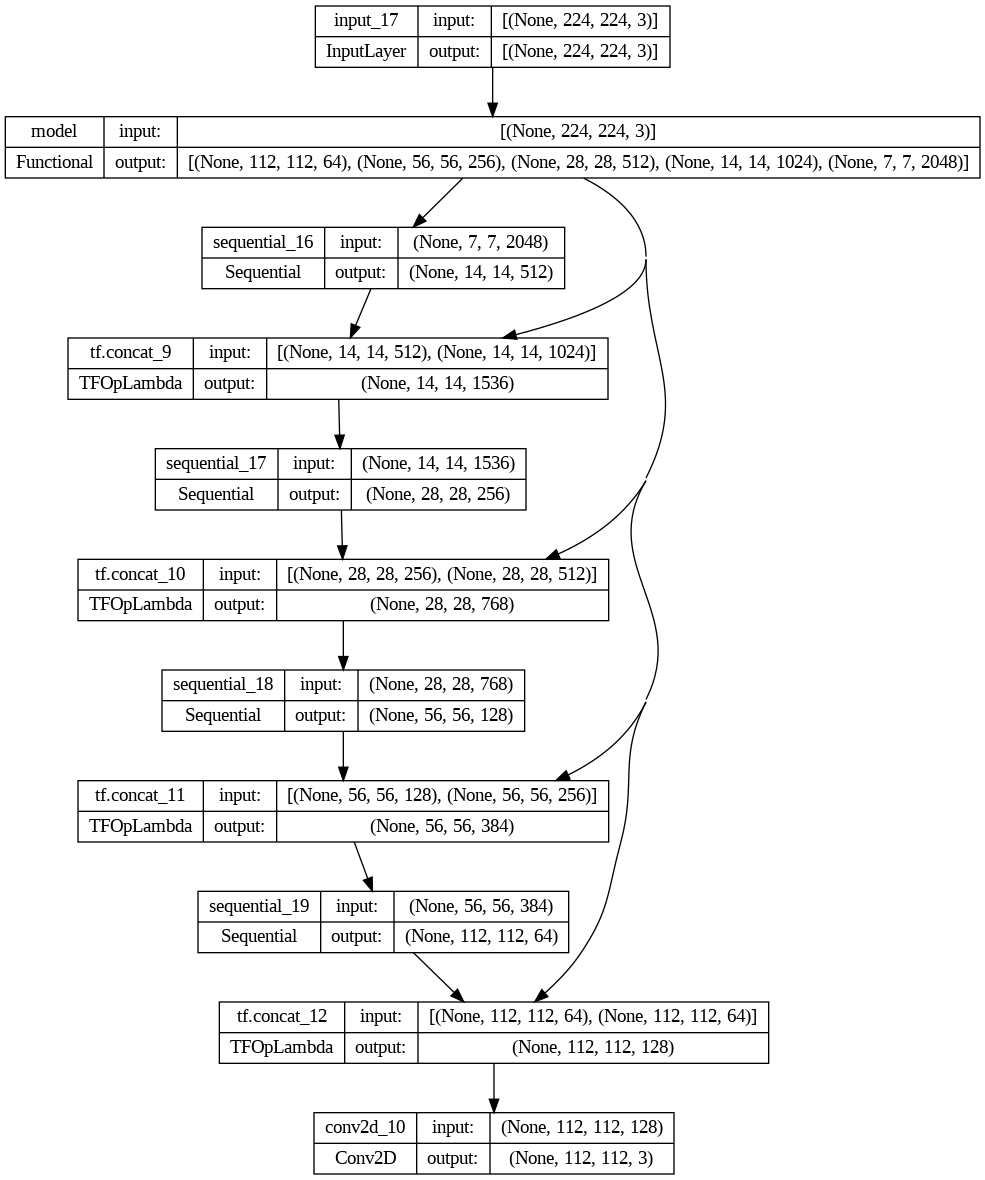

In [132]:
tf.keras.utils.plot_model(model, show_shapes=True)


In [133]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_2_history = model.fit(train_ds, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_ds,
                          callbacks=[checkpoint_callback])


Epoch 1/20
57/57 [==============================] - 93s 1s/step - loss: 0.7278 - accuracy: 0.6122 - val_loss: 1.1996 - val_accuracy: 0.6763
Epoch 2/20
57/57 [==============================] - 76s 1s/step - loss: 0.6687 - accuracy: 0.6473 - val_loss: 0.9010 - val_accuracy: 0.6977
Epoch 3/20
57/57 [==============================] - 71s 1s/step - loss: 0.6516 - accuracy: 0.6535 - val_loss: 0.9314 - val_accuracy: 0.7016
Epoch 4/20
57/57 [==============================] - 71s 1s/step - loss: 0.6398 - accuracy: 0.6581 - val_loss: 0.9034 - val_accuracy: 0.7075
Epoch 5/20
57/57 [==============================] - 71s 1s/step - loss: 0.6334 - accuracy: 0.6586 - val_loss: 0.8955 - val_accuracy: 0.6968
Epoch 6/20
57/57 [==============================] - 77s 1s/step - loss: 0.6223 - accuracy: 0.6635 - val_loss: 0.8551 - val_accuracy: 0.6898
Epoch 7/20
57/57 [==============================] - 83s 1s/step - loss: 0.6208 - accuracy: 0.6640 - val_loss: 0.8395 - val_accuracy: 0.7150
Epoch 8/20
57/57 [==

In [138]:
def plot_loss_and_acc_with_val(model_history):
  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']

  plt.figure()
  plt.plot(model_history.epoch, loss, 'r', label='Training loss')
  plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss Value')
  plt.legend()

  accuracy = model_history.history['accuracy']
  val_acc = model_history.history['val_accuracy']

  plt.figure()
  plt.plot(model_history.epoch, accuracy, 'r', label='Training Accuracy')
  plt.plot(model_history.epoch, val_acc, 'bo', label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy Value')
  plt.legend()
  plt.show()


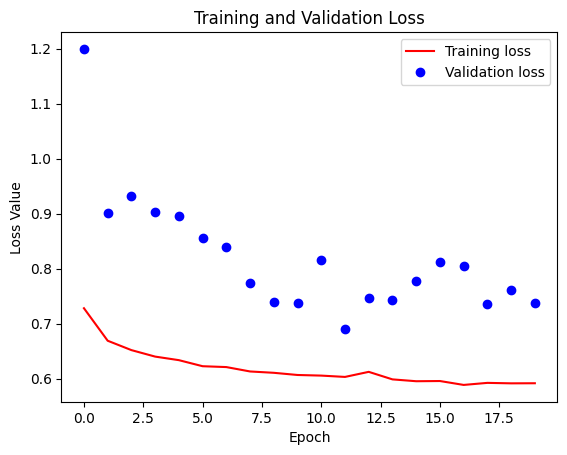

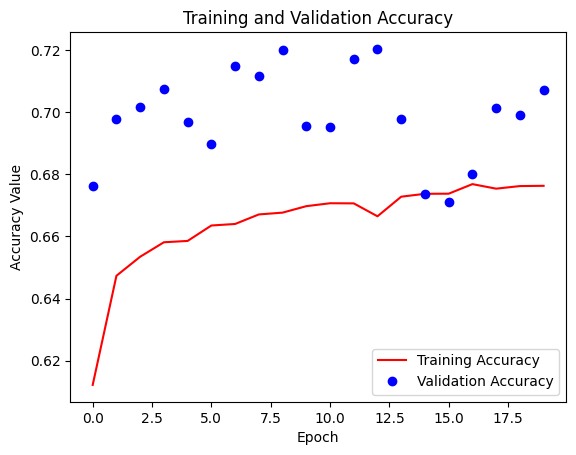

In [139]:
plot_loss_and_acc_with_val(model_2_history)

1/1 [==============================] - 0s 56ms/step


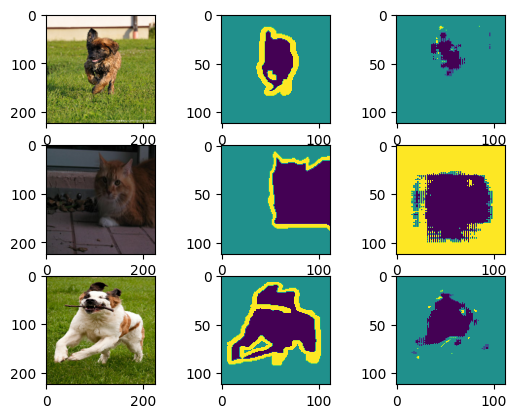

In [140]:
test_model(model)

## Lets use MobileNetV2

In [149]:
base_model_mb = tf.keras.applications.MobileNetV2(input_shape=[INPUT_DIM, INPUT_DIM, 3], include_top=False)

layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model_mb.get_layer(name).output for name in layer_names]

down_stack = Model(inputs=base_model_mb.input, outputs=base_model_outputs)

down_stack.trainable = False
down_stack.summary()


9406464/9406464 [==============================] - 1s 0us/step
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_26 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_26[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           

In [168]:
model_3 = unet_model(base_model=down_stack,output_channels=3)
model_3.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [169]:
model_3_history = model_3.fit(train_ds, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_ds,
                          callbacks=[checkpoint_callback])

Epoch 1/20
57/57 [==============================] - 74s 1s/step - loss: 0.5985 - accuracy: 0.7055 - val_loss: 2.2451 - val_accuracy: 0.4841
Epoch 2/20
57/57 [==============================] - 62s 1s/step - loss: 0.4390 - accuracy: 0.7487 - val_loss: 0.5994 - val_accuracy: 0.7908
Epoch 3/20
57/57 [==============================] - 58s 1s/step - loss: 0.4235 - accuracy: 0.7532 - val_loss: 0.4598 - val_accuracy: 0.8388
Epoch 4/20
57/57 [==============================] - 59s 1s/step - loss: 0.4194 - accuracy: 0.7533 - val_loss: 0.4357 - val_accuracy: 0.8441
Epoch 5/20
57/57 [==============================] - 57s 1s/step - loss: 0.4129 - accuracy: 0.7552 - val_loss: 0.4078 - val_accuracy: 0.8441
Epoch 6/20
57/57 [==============================] - 60s 1s/step - loss: 0.4039 - accuracy: 0.7578 - val_loss: 0.4056 - val_accuracy: 0.8445
Epoch 7/20
57/57 [==============================] - 58s 1s/step - loss: 0.4060 - accuracy: 0.7572 - val_loss: 0.3759 - val_accuracy: 0.8478
Epoch 8/20
57/57 [==

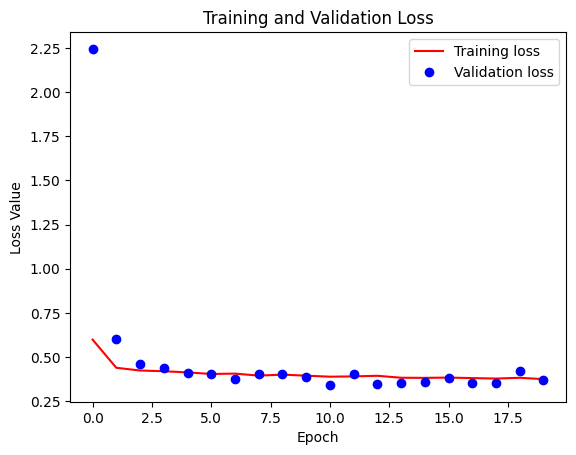

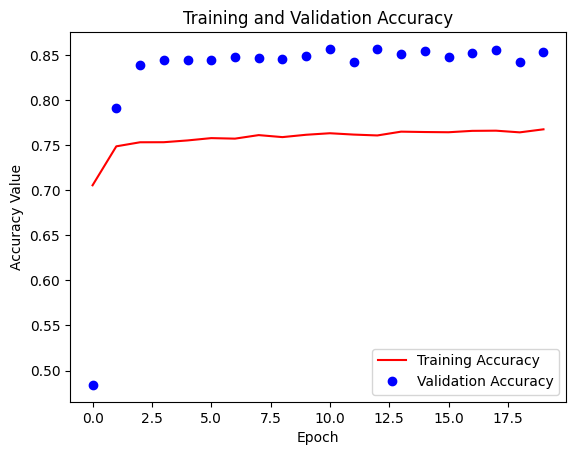

In [170]:
plot_loss_and_acc_with_val(model_3_history)

1/1 [==============================] - 0s 31ms/step


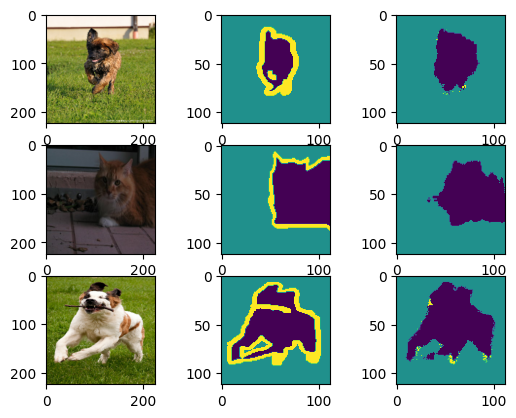

In [171]:
test_model(model_3)